# Airline Passenger Satisfaction
Elimelech Berlin  
October 2023

## Overview

## Data

## EDA

In [84]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn-v0_8')

In [34]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [2]:
# open zipped file & create a dataframe for each of the train/test subsets of the data
with zipfile.ZipFile('data/archive.zip', 'r') as zipped_file:
    for file in zipped_file.namelist():
        file_csv = zipped_file.open(file)
        file_df = pd.read_csv(file_csv)
        if file == 'test.csv':
            test_df = file_df
        if file == 'train.csv':
            train_df = file_df

In [3]:
print('# of rows in the train set: {}'.format(len(train_df)))
print('# of rows in the test set: {}'.format(len(test_df)))
print('This is equal to a train/test split of {}/{}'.format(int(len(train_df) / (len(train_df) + len(test_df)) * 100), int(len(test_df) / (len(train_df) + len(test_df)) * 100)))

# of rows in the train set: 103904
# of rows in the test set: 25976
This is equal to a train/test split of 80/20


To gain understanding of the dataset lets get a list of the dataframes columns & preview the first 5 rows:

In [4]:
# list column names
train_df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [5]:
# view first 5 rows of the dataframe
train_df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


> 2 points emerge from the above output:
>* In this report `'satisfaction'` is the target feature to be predicted by the rest of the features present in the dataset.  
>* Two columns are clearly irrelevant to this report: `'Unnamed: 0'` & `'id'`. Let's remove them from the dataframe:

In [6]:
train_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [7]:
# preprocessing performed to the test set
test_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

Accurding to the written down stuff about the data provided with the data, some of the columns contain subjective information provided by consumers surveyed about their past experiences. Such information may not be available when predicting overall satisfaction prior to a customer's survey response & should therefore be excluded from any model employed to predict a rating in order to bribe a customer at high risk of dissatisfaction in order to change his/her mind. (If the point of a model is too know who will be dissatisfied, in order to take measures to preemptively bribe them, we can't use as of yet unprovided ratings on 'food & drink service' to predict that info. A solution to this can be to request ratings for different elements of consumer experience as the service is provided. i.e. customers are asked to rate ease-of-online booking service immediately upon completion of booking, not as part of an overall survey.)

Now, check for missing values:

In [8]:
# train subset
train_df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [9]:
# test subset
test_df.isna().sum()

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

> The only column with missing values is `'Arrival Delay in Minutes'`. This cannot be understood as there being no delay for a given flight, as this would be recorded as `'0'` as seen for many such records present in the data:

In [10]:
train_df['Arrival Delay in Minutes'].value_counts()

Arrival Delay in Minutes
0.0      58159
1.0       2211
2.0       2064
3.0       1952
4.0       1907
         ...  
458.0        1
729.0        1
382.0        1
459.0        1
369.0        1
Name: count, Length: 455, dtype: int64

> There are thousands of rows with `'0'` recorded for arrival delay, so null doesn't necasserily mean there wasn't a delay.
Let's impute the mean of the column's values for those that are missing;

In [11]:
# train subset
# impute missing values with column mean
train_df['Arrival Delay in Minutes'].fillna(train_df['Arrival Delay in Minutes'].mean(), inplace=True)

# check to ensure that null values were replaced
train_df['Arrival Delay in Minutes'].isna().value_counts()

Arrival Delay in Minutes
False    103904
Name: count, dtype: int64

In [12]:
# test subset
# impute missing values with column mean
test_df['Arrival Delay in Minutes'].fillna(test_df['Arrival Delay in Minutes'].mean(), inplace=True)

# check to ensure that null values were replaced
test_df['Arrival Delay in Minutes'].isna().value_counts()

Arrival Delay in Minutes
False    25976
Name: count, dtype: int64

Let's continue the preprocessing step by examining data types present in each column:

In [13]:
train_df.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

> Several columns contain non-numeric data types. These most be modified before any attempt at modelling. Columns with binary values can be simply mapped to `'0'` or `'1'`; columns with more than 2 values must be one-hot encoded.

In [14]:
# get a list of non-numeric categorical columns
xnum_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
# view list
xnum_cols

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

In [15]:
# create column with binary values
# identify categorical columns with binary values
for col in xnum_cols:
#     modify only columns with binary values
    if len(train_df[col].unique()) == 2:
#         display column name, values
        print(col, train_df[col].unique())
#         get name for new column
        new_name = train_df[col].unique()[1]
#         create column with second unique value & map values to binary
        train_df[new_name] = train_df[col].map({train_df[col].unique()[0]:0, train_df[col].unique()[1]:1})
#         modify set dataframe    
        test_df[new_name] = test_df[col].map({test_df[col].unique()[0]:0, test_df[col].unique()[1]:1})
    #   remove original column
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

Gender ['Male' 'Female']
Customer Type ['Loyal Customer' 'disloyal Customer']
Type of Travel ['Personal Travel' 'Business travel']
satisfaction ['neutral or dissatisfied' 'satisfied']


In [16]:
train_df.columns

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Female', 'disloyal Customer', 'Business travel', 'satisfied'],
      dtype='object')

> The above output reveals that the column `'disloyal Customer'` describes a customer's loyalty status. To keep things as intuitive as possible, switch the column to be describing a positive state (customer loyalty) instead of a negative state (customer disloyalty).

In [17]:
# replace 'disloyal Customer' with 'Loyal Customer'
# create 'Loyal Customer' column
train_df['Loyal Customer'] = train_df['disloyal Customer'].map({0:1, 1:0})
test_df['Loyal Customer'] = test_df['disloyal Customer'].map({0:1, 1:0})

# view both columns to ensure the values are oppposites of each other
train_df[['disloyal Customer', 'Loyal Customer']]

,disloyal Customer,Loyal Customer
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
103899,1,0
103900,0,1
103901,1,0
103902,1,0


In [18]:
# remove 'disloyal Customer' column
train_df.drop('disloyal Customer', axis=1, inplace=True)
test_df.drop('disloyal Customer', axis=1, inplace=True)

Now, one-hot encode categorical column with more than 2 values:

In [19]:
# one hot encode remaining categorical columns
all_num_train_df = pd.get_dummies(train_df)
all_num_train_df

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Female,Business travel,satisfied,Loyal Customer
0,13,460,3,4,3,1,5,3,5,5,...,4,4,5,5,25,18.0,0,0,0,1
1,25,235,3,2,3,3,1,3,1,1,...,3,1,4,1,1,6.0,0,1,0,0
2,26,1142,2,2,2,2,5,5,5,5,...,4,4,4,5,0,0.0,1,1,1,1
3,25,562,2,5,5,5,2,2,2,2,...,3,1,4,2,11,9.0,1,1,0,1
4,61,214,3,3,3,3,4,5,5,3,...,4,3,3,3,0,0.0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,23,192,2,1,2,3,2,2,2,2,...,4,2,3,2,3,0.0,1,1,0,0
103900,49,2347,4,4,4,4,2,4,5,5,...,5,5,5,4,0,0.0,0,1,1,1
103901,30,1995,1,1,1,3,4,1,5,4,...,4,5,5,4,7,14.0,0,1,0,0
103902,22,1000,1,1,1,5,1,1,1,1,...,1,5,4,1,0,0.0,1,1,0,0


In [20]:
all_num_test_df = pd.get_dummies(test_df)

In [21]:
# ensure the subsets have the same column names
assert [col for col in all_num_train_df.columns] == [col for col in all_num_test_df.columns]

To check data for any obvious patterns or autocorrelation, view a corellation heatmap:

In [59]:
all_num_train_df.corr()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Arrival Delay in Minutes,Female,Business travel,satisfied,Loyal Customer
Age,1.000000,0.099461,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,0.076444,...,0.040583,-0.047529,0.035482,-0.049427,0.053611,-0.012127,-0.008928,0.048524,0.137167,0.281674
Flight Distance,0.099461,1.000000,0.007131,-0.020043,0.065717,0.004793,0.056994,0.214869,0.157333,0.128740,...,0.133916,0.063184,0.073072,0.057540,0.093149,-0.002423,-0.005828,0.267344,0.298780,0.225200
Inflight wifi service,0.017859,0.007131,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,0.209321,...,0.160473,0.120923,0.043193,0.110441,0.132698,-0.019067,-0.008974,0.105085,0.284245,0.007543
Departure/Arrival time convenient,0.038125,-0.020043,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,-0.004861,...,0.012441,0.072126,0.093333,0.073318,0.014292,-0.000863,-0.009142,-0.259763,-0.051601,0.206869
Ease of Online booking,0.024842,0.065717,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,0.047032,...,0.107601,0.038762,0.011081,0.035272,0.016179,-0.007972,-0.006951,0.133511,0.171705,0.019509
Gate location,-0.001330,0.004793,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,0.003517,...,-0.005873,0.002313,-0.035427,0.001681,-0.003830,0.005136,-0.000333,0.030700,0.000682,-0.006078
Food and drink,0.023000,0.056994,0.134718,0.004906,0.031873,-0.001159,1.000000,0.234468,0.574556,0.622512,...,0.032498,0.034746,0.087299,0.033993,0.657760,-0.032472,-0.005772,0.063439,0.209936,0.059454
Online boarding,0.208939,0.214869,0.456970,0.070119,0.404074,0.001688,0.234468,1.000000,0.420211,0.285066,...,0.123950,0.083280,0.204462,0.074573,0.331517,-0.021915,0.042260,0.224803,0.503557,0.189262
Seat comfort,0.160277,0.157333,0.122658,0.011344,0.030014,0.003669,0.574556,0.420211,1.000000,0.610590,...,0.105559,0.074542,0.191854,0.069218,0.678534,-0.029851,0.026502,0.124399,0.349459,0.159484
Inflight entertainment,0.076444,0.128740,0.209321,-0.004861,0.047032,0.003517,0.622512,0.285066,0.610590,1.000000,...,0.299692,0.378210,0.120867,0.404855,0.691815,-0.030658,-0.006117,0.148199,0.398059,0.109930


<Axes: >

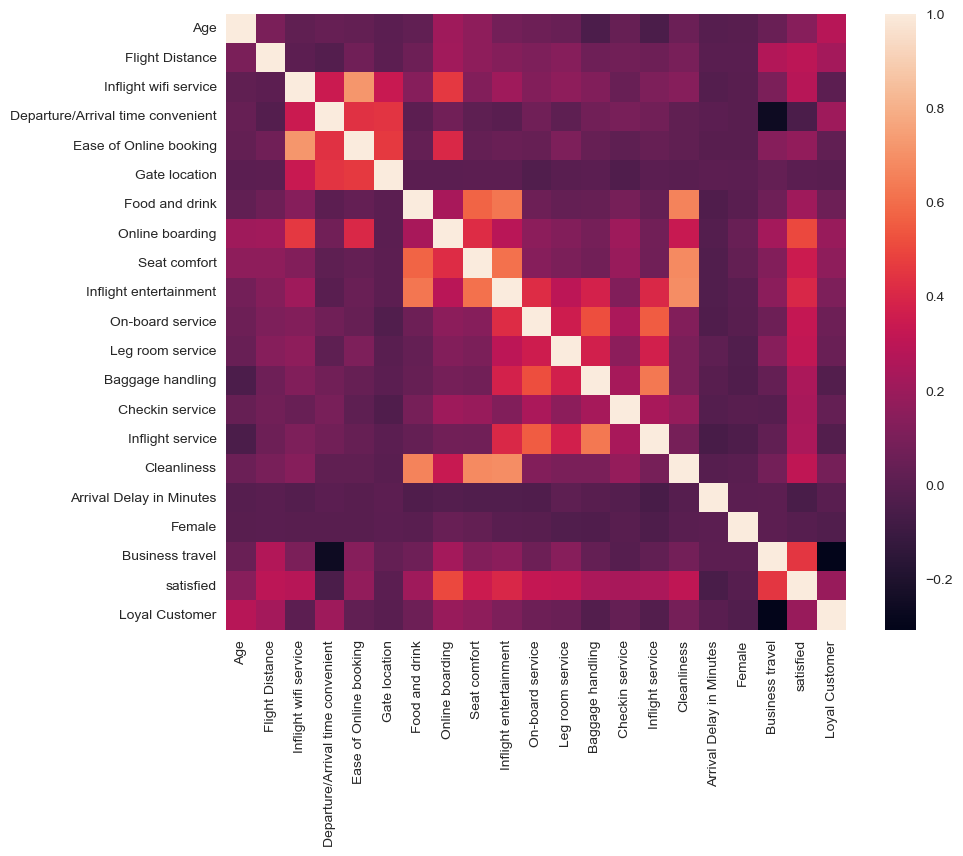

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(all_num_train_df.corr())

> The above plot shows that, unsurprisingly, there is strong correlation between `'Departure Delay in Minutes'` & `'Arrival Delay in Minutes'`. Let's examine their correlation:

In [23]:
all_num_train_df.corr()['Departure Delay in Minutes']['Arrival Delay in Minutes']

0.9611607683973858

> Indeed, the two are closely correlated. To avoid any issues in modeling arrising from this, let's remove one of those columns. Let's drop the one that has a weaker correlation with `'satisfied'`.

In [24]:
[{col : all_num_train_df.corr()['satisfied'][col]} for col in all_num_train_df.columns if 'Delay' in col]

[{'Departure Delay in Minutes': -0.050494210261235115},
 {'Arrival Delay in Minutes': -0.057496815057623676}]

> `'Arrival Delay in Minutes'` has slightly greater correlation with `'satisfied'` than `'Departure Delay in Minutes'`; drop `'Departure Delay in Minutes'` column from the dataframe:

In [30]:
all_num_test_df.columns

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Arrival Delay in Minutes', 'Female', 'Business travel',
       'satisfied', 'Loyal Customer'],
      dtype='object')

In [28]:
# train test
all_num_train_df.drop(['Departure Delay in Minutes'], axis=1, inplace=True)
# test set
all_num_test_df.drop(['Departure Delay in Minutes'], axis=1, inplace=True)

KeyError: "['Departure Delay in Minutes'] not found in axis"

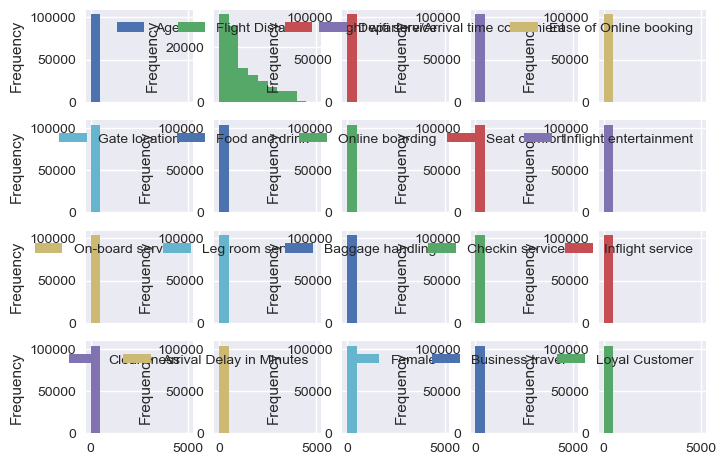

In [37]:
all_num_train_df.drop('satisfied', axis=1).plot.hist(subplots=True, layout=(4, 5));

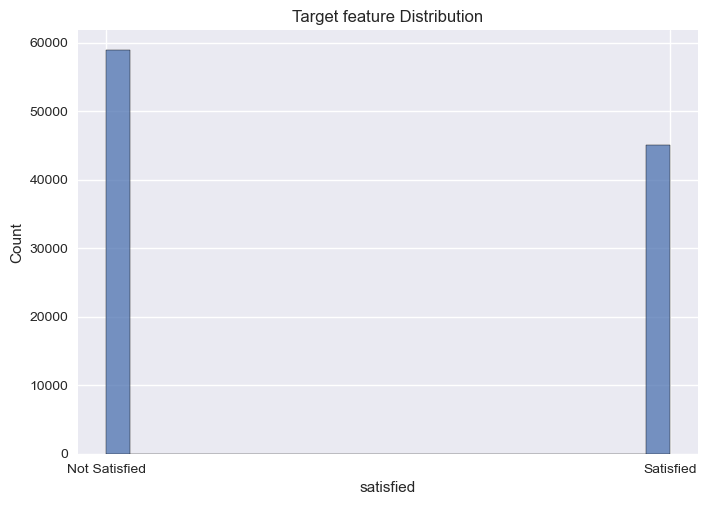

In [63]:
sns.histplot(all_num_train_df['satisfied'])
plt.title('Target feature Distribution')
plt.xticks(ticks=[0, 1], labels=['Not Satisfied', 'Satisfied']);

#### Minimize Number of Features to Model
(Consider using the list developed in this subsection in modeling to reduce model complexity.)  
To minimize the number of predictor features, remove any features whose correlation with the target feature is smaller than .1:

Text(0.5, 0.8, "Feature Correlation w/ 'satisfied'")

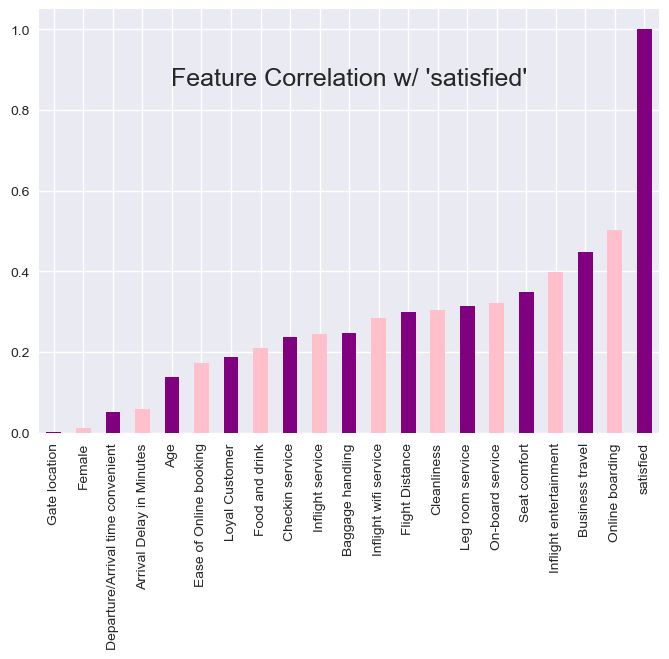

In [39]:
# view ordered list of features with their correlation to 'satisfied'
all_num_train_df.corr()['satisfied'].abs().sort_values().plot(kind='bar', color=['purple', 'pink'])
plt.title("Feature Correlation w/ 'satisfied'", fontsize=18, y=.8)

In [40]:
# get a list of columns whose correlation to 'satisfied' is greater than .1 (& exclude 'satisfied')
high_corr_list = []
for col in all_num_train_df:
    if 1 != abs(all_num_train_df[col].corr(all_num_train_df['satisfied'])) >= .1:
        high_corr_list.append(col)
        
high_corr_list

['Age',
 'Flight Distance',
 'Inflight wifi service',
 'Ease of Online booking',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Business travel',
 'Loyal Customer']

In [45]:
# create a new dataframe consisting of features with high correlation only
X_train = all_num_train_df[high_corr_list]

# test dataframe
X_test = all_num_test_df[high_corr_list]

Because the range of values found in each of the columns is inconsistent, the values need to be scaled before modeling.

In [46]:
scaler = StandardScaler()

In [47]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(all_num_train_df.drop(['satisfied'], axis=1)), columns = all_num_train_df.drop(['satisfied'], axis=1).columns)

In [48]:
y_train = all_num_train_df['satisfied']

In [49]:
X_test_scaled = pd.DataFrame(scaler.transform(all_num_test_df.drop(['satisfied'], axis=1)), columns = all_num_test_df.drop(['satisfied'], axis=1).columns)

In [50]:
y_test = all_num_test_df['satisfied']

## Modeling
In this section, several attempts at modeling are made, with several different algorithms.

In [51]:
baseline_log = LogisticRegression()

In [52]:
baseline_log.fit(X_train_scaled, y_train)

LogisticRegression()

In [53]:
y_hat_train = baseline_log.predict(X_train_scaled)

In [54]:
y_hat_test = baseline_log.predict(X_test_scaled)

#### Model Assesment
The business case considered for this report dictates that model performance be measured by fit's ability to find those who will be dissatisfied, thus recall for calss 0 is the metric of focus.

In [55]:
train_class_rep = pd.DataFrame(classification_report(y_train, y_hat_train, output_dict=True))

In [56]:
test_class_rep = pd.DataFrame(classification_report(y_test, y_hat_test, output_dict=True))

In [64]:
test_class_rep

,0,1,accuracy,macro avg,weighted avg
precision,0.425327,0.526136,0.453688,0.475731,0.481882
recall,0.696308,0.263844,0.453688,0.480076,0.453688
f1-score,0.528084,0.351446,0.453688,0.439765,0.428987
support,11403.000000,14573.000000,0.453688,25976.000000,25976.000000


In [57]:
pos_clas_df = pd.concat([pd.DataFrame(train_class_rep['1']), pd.DataFrame(test_class_rep['1'])], axis=1)

<Axes: >

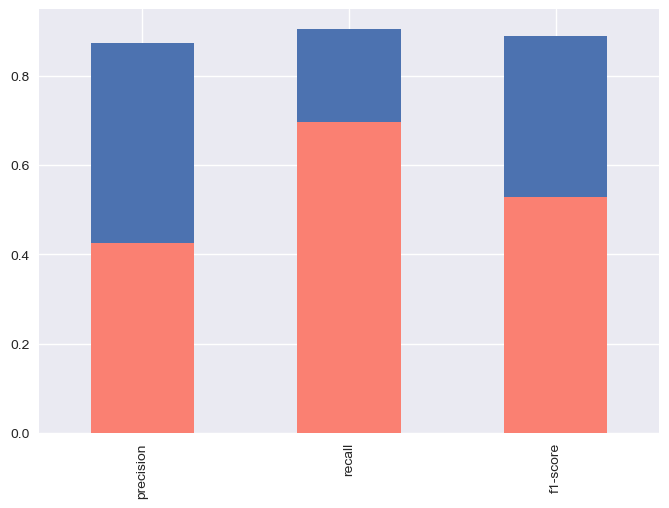

In [65]:
train_class_rep['0'].drop('support').plot(kind='bar', stacked=False)
test_class_rep['0'].drop('support').plot(kind='bar', color='salmon', stacked=False)

The model underperforms on the test set compared to the train set. It's underfit. Regularization may reduce this.

In [78]:
# logistic regression with various regularization levels
recall_list = {}

for c in [2, 20, 200, 2000, 20000]:
    log_reg = LogisticRegression(C = c, random_state=42)
    log_reg.fit(X_train_scaled, y_train)
    test_pred = log_reg.predict(X_test_scaled)
    recall_list[c] = recall_score(y_test, test_pred)

recall_list

{2: 0.2638440952446305,
 20: 0.2638440952446305,
 200: 0.2638440952446305,
 2000: 0.2638440952446305,
 20000: 0.2638440952446305}

> Regularization doesn't help to improve model's performance.
Now let's try a different modeling algorithm.

In [83]:
rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train_scaled, y_train)

rfc_train_pred = rfc.predict(X_train_scaled)
rfc_test_pred = rfc.predict(X_test_scaled)

recall_score(y_test, rfc_test_pred)

0.23996431757359502

> That's even worse than the logistic regression classifier! Maybe tweaking some of the hyperparameters will produce better results.

In [ ]:
grid = 

new modeling techniques, model stacking, use seaborn, create (local) dashboard (most important features, make predictions), final nontebook contains only pipelines